<a href="https://colab.research.google.com/github/Roger-G/Data-augmentation/blob/master/Bert_classification_sub_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import package


In [0]:
!pip install transformers
!pip install pysnooper
import pandas as pd
import torch
from sklearn.metrics import multilabel_confusion_matrix
from torch import nn
from sklearn.metrics import precision_recall_fscore_support as score
import sys
from tqdm import trange
import numpy as np

import os
from collections import Counter
from IPython.display import clear_output
from torch.utils.data import Dataset
import seaborn as sns
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
import torch
import pysnooper
# Load English tokenizer, tagger,  
# parser, NER and word vectors 
import re
from random import sample
from sklearn.utils import resample
import os.path as path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
absFilePath_aug = '/content/drive/My Drive/Data/Bert_ data augmentation-master/aug_data/rt-polaritydata/replacement/'
absFilePath = '/content/drive/My Drive/Data/Bert_ data augmentation-master/'
absFile_originaldata = '/content/drive/My Drive/Data/Bert_ data augmentation-master/datasets/rt-polaritydata/'
clear_output()

In [2]:
PRETRAINED_MODEL_NAME = "bert-base-uncased"  
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
print("PyTorch version", torch.__version__)


PyTorch version 1.5.0+cu101


## Prepro_Data

In [0]:
class Prepro_Data(Dataset):
  
  def __init__(self, path, tokenizer, text_file_name, max_length=30):

    self.text, self.label = self.preprocess(text_file_name, max_length, path)    
    self.tokenizer = tokenizer
    self.path = path

  def __getitem__(self, idx):
    
    text, label = self.text[idx], self.label[idx]
    tokens = text.split()
    word_pieces = ['[CLS]'] + tokens + ['[SEP]']
    ids = self.tokenizer.convert_tokens_to_ids(tokens)
    label_tensor = torch.tensor(label)
    tokens_tensor = torch.tensor(ids)
    segments_tensor = torch.zeros_like(tokens_tensor)  # (1, seq_len)

    return (tokens_tensor, label_tensor)
  
  def  __len__(self):      
    return len(self.text)

  @staticmethod
  def load_data(path_, FILE_NAME):
    
    df_train = pd.read_csv(os.path.join(path_,'train.tsv'), sep='\t',  error_bad_lines=False)
    df_train = df_train.dropna()
    num_DA = max(df_train.label.value_counts()) - min(df_train.label.value_counts())

    if FILE_NAME != 'oversampling':
      df = pd.read_csv(os.path.join(path_, FILE_NAME + '.tsv'), sep='\t',  error_bad_lines=False)    
      df = df.dropna()

    else:
      # 选出差额， 补到原数据上面
      df_over_samp = resample(df_train[df_train.label==0], n_samples=num_DA, random_state=100, replace=True)
      df = pd.concat([df_over_samp, df_train])

    if FILE_NAME != 'train' and FILE_NAME != 'dev' and FILE_NAME != 'oversampling' and FILE_NAME != 'test':
      try:
        df_over_samp = resample(df, n_samples=num_DA, replace = False, random_state=10) 
        
      except ValueError:
        df_over_samp = resample(df, n_samples=num_DA, replace = True, random_state=10) 

      df = pd.concat([df_train, df_over_samp]) 

    else: 
      pass
    
    df = df.sample(frac = 1, replace=False, random_state=102)  

    return df

  @classmethod
  def preprocess(clf, FILE_NAME, max_length, path):
    data = clf.load_data(path, FILE_NAME)
    # print('all data', len(data))
    data = data[~(data.sentence.apply(lambda x : len(x.split()) > max_length))]
    # print('selected data', len(data))
    text, label = data.iloc[:, 0].values, data.iloc[:, 1].values

    return text, label

In [0]:
# data = pd.read_csv('/content/drive/My Drive/Data/Bert_ data augmentation-master/aug_data/twitter/train.tsv', sep='\t')
# length = []
# for x in data.sentence:
#   # print(x)
#   length.append(len(x.split()))
# print('mean', np.mean(length))
# length

In [0]:
def create_mini_batch(samples):

    tokens_tensors = [s[0] for s in samples]
    if samples[0][1] is not None:
        label_ids = torch.stack([s[1] for s in samples])
    else:
        label_ids = None
        
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    masks_tensors = torch.zeros(tokens_tensors.shape,
                               dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    return tokens_tensors, masks_tensors, label_ids

## Model

In [14]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def load_model():
  
  NUM_LABELS = 4
  model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME,
                                                     num_labels=NUM_LABELS)
  model.to(device)
  return model

model = load_model()
# model.dropout = nn.Dropout(0.3)
print("""
name            module
----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))


name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=768, out_features=4, bias=True)


In [0]:
# param_optimizer = list(model.named_parameters())
# no_decay = ['bias', 'gamma', 'beta']
# optimizer_grouped_parameters = [
#     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
#      'weight_decay_rate': 0.01},
#     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
#      'weight_decay_rate': 0.0}
# ]

# optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=2e-5,
#                      warmup = 0.1)

## Utils

In [0]:
class utils():
  
  def __init__(self, EPOCHS):
    self.EPOCHS = EPOCHS

  def acc_loss(self, list_train_acc, list_val_acc, list_train_loss, list_val_loss):
    fig = plt.figure(figsize=(10, 5))
    
    
    ax1 = fig.add_subplot(1, 2, 1)
    sns.lineplot(ax=ax1, data=pd.DataFrame(list(zip(list_train_acc, list_val_acc)), columns=['training acc', 'validation acc'], index = range(1, len(list_val_acc)+1)))
    ax1.set(xlabel='Epochs', ylabel='Accuracy')
    ax1.locator_params(integer=True)

    ax2 = fig.add_subplot(1, 2, 2)
    sns.lineplot(ax=ax2, data=pd.DataFrame(list(zip(list_train_loss, list_val_loss)), columns=['training loss', 'validation loss'], index = range(1, len(list_val_loss)+1)))
    ax2.set(xlabel='Epochs', ylabel='Loss')
    ax2.locator_params(integer=True)
    plt.show()
  
  @staticmethod
  def draw_final(eval_dic, test_list_name):
    
    for eval_name, eval_list in eval_dic.items():
      sns.set(style="white", context="talk")
      plt.figure(figsize=(10,5)) 
      g = sns.barplot(x=np.array(eval_list), y=np.array(test_list_name), palette="deep")
      ax=g
    
      for p in ax.patches:
        ax.annotate("%.2f" % p.get_width(), (p.get_width(), p.get_y() + p.get_height() / 2.),
          fontsize=12, color='gray', xytext=(10, 0), textcoords='offset points')
    
      ax.axhline(0, color="k", clip_on=False)
      ax.set_xlabel(eval_name)
      # ax.set_ylabel("Methods")

  @staticmethod
  def path_setting(task_name, tech_name = 'Bert_ data augmentation-master'):
    abspath = '/content/drive/My Drive/Data/'
    model_path = path.join(abspath, tech_name + '/save_model')
    dataset_path = path.join(abspath, tech_name + '/datasets/{}/'.format(task_name))
    save_path = path.join(abspath, tech_name + '/aug_data/{}/'.format(task_name))
    return model_path, dataset_path, save_path

  @staticmethod
  def eval_matrix(list_array_value):
    fig = plt.figure(figsize=(12, 5))
  
    for i, array_value in enumerate(list_array_value):
      df = pd.DataFrame(array_value, columns=["0", "1", "2"], index=range(1,len(array_value)+1))
      ax = fig.add_subplot(1, 3, i+1)
      sns.lineplot(data=df, palette="tab10", ax=ax)
      ax.set(xlabel='Epochs', ylabel=['precision', 'recall', 'fscore'][i])

    plt.show()
  
  @staticmethod
  def draw_other_final(list_array_dic, test_list):

    for eval_name, list_array in list_array_dic.items():
      fig1 = plt.figure(figsize=(10, 5))
      barWidth = 0.07
      colors = ['#486093', '#BF7651', '#4F8F5B', '#A4484E', '#72659A', '#7A6553', '#C47FB2']
      # Set position of bar on X axis
      r1 = np.arange(len(list_array[0]))
      plt.bar(r1, list_array[0], color=colors[0], width=barWidth, edgecolor='white', label=test_list[0])
      for i in range(1, len(list_array)):
        r1 = [x + barWidth for x in r1] 
        plt.bar(r1, list_array[i], color=colors[i], width=barWidth, edgecolor='white', label=test_list[i])  
    
      # Add xticks on the middle of the group bars
      plt.xlabel('class', fontweight='bold')
      plt.xticks([r + barWidth for r in range(len(list_array[0]))], ['negative', 'neutral', 'positive'])
      plt.ylabel(eval_name)
      # Create legend & Show graphic
      plt.legend()
      plt.show()
    


## Training

In [0]:
class train_pre():

  def __init__(self, model, file_name, task_name, tech_name, epochs):
    self.model = model
    self.file_name = file_name
    self.task_name = task_name
    self.tech_name = tech_name
    self.epochs = epochs

  def get_predictions(self, dataset):
    predictions = None
    correct = 0
    total = 0
    loss_list = []

    with torch.no_grad():
      label_list = list()
      pred_list = list()

      for data in dataset:
        if next(self.model.parameters()).is_cuda:
          data = [t.to('cuda:0') for t in data if t is not None] 

        tokens_tensors, masks_tensors, labels = data
        loss, logits = self.model(input_ids=tokens_tensors,
                        attention_mask=masks_tensors,
                        labels = labels)
        
        _, pred = torch.max(logits.data, 1) 
        loss_list.append(loss.item())
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        label_list.extend(labels.tolist())
        pred_list.extend(pred.tolist())

        if predictions is None:
          predictions = pred
        else:
          predictions = torch.cat((predictions, pred))
    # got all the evalution results for every class.
    self.precision, self.recall, self.fscore, _ = score(label_list, pred_list) # 每个 class 单独的参数
    # the second score function is to get average score of evaluation matrix.
    self.precision_avg, self.recall_avg, self.fscore_avg, _ = score(label_list, pred_list, average='macro' ) 
    acc = correct / total

    return acc, np.mean(loss_list)

  def training(self, optimizer, patient=3):
  
    self.model.train()
    best_acc = 0
    sum_acc = 0
    best_loss = float("inf")
    num_train_samples = len(self.train_loader)
    num_val_samples = len(self.dev_loader)
    draw_train_loss = []
    draw_train_acc = []
    draw_val_loss = []
    draw_val_acc = []
    model_sel = []
    count = 0

    for epoch in range(self.epochs):
      running_loss = 0.0
      val_loss = 0.0

      for data in self.train_loader:
        tokens_tensors, masks_tensors, labels = [t.to(device) for t in data]
        optimizer.zero_grad()
        outputs = self.model(input_ids=tokens_tensors,
                        attention_mask=masks_tensors,
                        labels=labels)
        
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        # running_loss += loss.item()
        loss.detach()

      torch.cuda.empty_cache() 
      train_acc, train_loss = self.get_predictions(self.train_loader)

      val_acc, val_loss = self.get_predictions(self.dev_loader)

      if best_loss > val_loss:
        best_loss = val_loss
        best_acc = val_acc
        count = 0
        model_sel = []
      
      model_sel.append(self.model)
      print('[epoch %d] train_loss: %.3f, train_acc:%.3f, val_loss: %.3f, val_acc:%.3f' % 
            (epoch + 1, train_loss, train_acc, val_loss, val_acc))
      
      count += 1
      
      if count > patient:
        torch.save(self.model_path, '{}.pt'.format(self.file_name))
        break

      draw_train_loss.append(train_loss)
      draw_train_acc.append(train_acc)
      draw_val_loss.append(val_loss)
      draw_val_acc.append(val_acc)

    # torch.save({'state_dict': self.model.state_dict()}, path.join(self.model_path,'{}.pt'.format(self.file_name)))
    draw = utils(len(draw_train_acc))
    draw.acc_loss(draw_train_acc, draw_val_acc, draw_train_loss, draw_val_loss)

    ''' when testing, do not comment them'''
    # self.model = model_sel[0]
    # test_acc, test_loss = self.get_predictions(self.test_loader)
    
    # return test_acc, test_loss
    return val_acc, val_loss

  def setting(self):

    self.model_path, dataset_path, save_path = utils.path_setting(self.task_name, self.tech_name)

    if self.tech_name == 'Bert_ data augmentation-master' and self.task_name == 'toxic':
      path_ = os.path.join(save_path, 'replacement')
    else:
      path_ = save_path

    optimizer = torch.optim.Adam(self.model.parameters(), lr= 2e-6)
    BATCH_SIZE = 64
    trainset = Prepro_Data(path=path_, tokenizer=tokenizer, text_file_name=self.file_name)
    self.train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

    train_acc, _ = self.get_predictions(self.train_loader)
    print('\n', 'before training model, the accuracy is {}'.format(train_acc))
    devset = Prepro_Data(path=path_, tokenizer=tokenizer, text_file_name='dev') # 对 dev data preprocess
    testset = Prepro_Data(path=path_, tokenizer=tokenizer, text_file_name='test') # 对 dev data preprocess
    
    self.dev_loader = DataLoader(devset, BATCH_SIZE, collate_fn=create_mini_batch)
    self.test_loader = DataLoader(testset, BATCH_SIZE, collate_fn=create_mini_batch)
    acc, loss = self.training(optimizer, patient=3)
    # _, acc = get_predictions(trained_model, testloader, compute_acc=True)
    print('After training model_{}, the accuracy is {}'.format(self.file_name, acc))

    return acc, loss, self.precision_avg, self.recall_avg, self.fscore_avg, self.precision, self.recall, self.fscore



## Run

In [0]:

def execute(test_list, tech_name, task_name):
  
  acc_list = []
  epochs = 20
  loss_list = []
  precision_list = []
  recall_list = []
  fscore_list = []
  list_prec = []
  list_recall = []
  list_fs = []
  for i, file_name in enumerate(test_list):
    print('-' * 70)
    print('Start to train model use the data : {}'.format(file_name))
    print('-' * 70)
    model = load_model()
    train = train_pre(model, file_name, task_name, tech_name, epochs=epochs)
    acc, loss, precision_avg, recall_avg, fscore_avg, precision, recall, fscore = train.setting()
    
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

    acc_list.append(acc)
    loss_list.append(loss)
    list_prec.append(precision_avg)
    list_recall.append(recall_avg)
    list_fs.append(fscore_avg)
  
  print('acc_list', acc_list)
  print('loss_list', loss_list)
  print('precision_list', precision_list)
  print('recall_list', recall_list)
  print('fscore_list', fscore_list)
  print('average prec', list_prec)
  print('average recall', list_recall)
  print('average fs', list_fs)

  utils.draw_final({'loss': loss_list, 'accuracy': acc_list, 
                    'average fscore': list_fs, 'average precision': list_prec,
                    'average recall': list_recall}, test_list)

  utils.draw_other_final( {'precision': precision_list, 
                    'recall': recall_list, 'fscore': fscore_list}, test_list)



### EDA

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------

 before training model, the accuracy is 0.08921341315707512


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[epoch 1] train_loss: 0.831, train_acc:0.612, val_loss: 0.831, val_acc:0.612
[epoch 2] train_loss: 0.742, train_acc:0.663, val_loss: 0.744, val_acc:0.658
[epoch 3] train_loss: 0.688, train_acc:0.684, val_loss: 0.705, val_acc:0.675
[epoch 4] train_loss: 0.660, train_acc:0.700, val_loss: 0.689, val_acc:0.679
[epoch 5] train_loss: 0.640, train_acc:0.706, val_loss: 0.682, val_acc:0.683
[epoch 6] train_loss: 0.618, train_acc:0.722, val_loss: 0.672, val_acc:0.695
[epoch 7] train_loss: 0.601, train_acc:0.733, val_loss: 0.672, val_acc:0.697
[epoch 8] train_loss: 0.585, train_acc:0.739, val_loss: 0.677, val_acc:0.688
[epoch 9] train_loss: 0.566, train_acc:0.749, val_loss: 0.676, val_acc:0.695


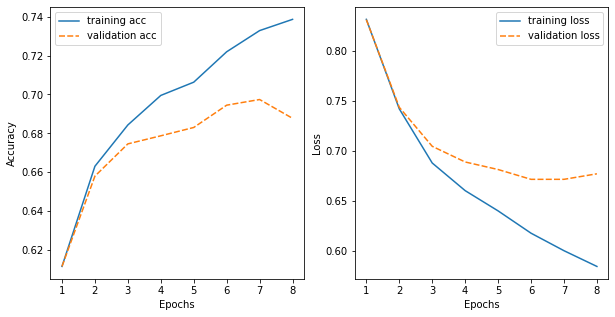

After training model_train, the accuracy is 0.6910722197607444
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------

 before training model, the accuracy is 0.34517342248223987
[epoch 1] train_loss: 0.823, train_acc:0.631, val_loss: 0.891, val_acc:0.551
[epoch 2] train_loss: 0.704, train_acc:0.693, val_loss: 0.803, val_acc:0.610
[epoch 3] train_loss: 0.636, train_acc:0.726, val_loss: 0.764, val_acc:0.635
[epoch 4] train_loss: 0.583, train_acc:0.751, val_loss: 0.786, val_acc:0.633
[epoch 5] train_loss: 0.541, train_acc:0.770, val_loss: 0.750, val_acc:0.658
[epoch 6] train_loss: 0.496, train_acc:0.789, val_loss: 0.772, val_acc:0.655
[epoch 7] train_loss: 0.465, train_acc:0.803, val_loss: 0.747, val_acc:0.672
[epoch 8] train_loss: 0.438, train_acc:0.813, val_loss: 0.755, val_acc:0.679
[epoch 9] train_loss: 0.414, train_acc:0.822, val_loss: 0.764, val_ac

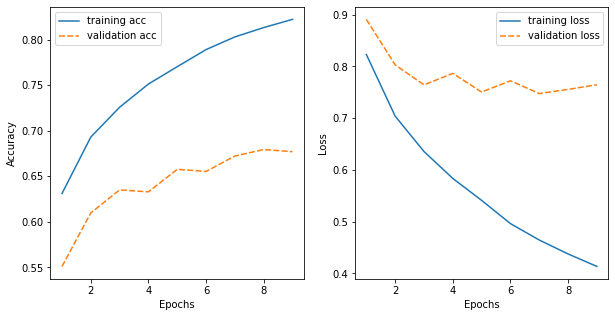

After training model_oversampling, the accuracy is 0.6793309703145769
----------------------------------------------------------------------
Start to train model use the data : 2_del
----------------------------------------------------------------------

 before training model, the accuracy is 0.3438796298569009
[epoch 1] train_loss: 0.810, train_acc:0.634, val_loss: 0.878, val_acc:0.555
[epoch 2] train_loss: 0.703, train_acc:0.692, val_loss: 0.806, val_acc:0.608
[epoch 3] train_loss: 0.639, train_acc:0.722, val_loss: 0.786, val_acc:0.628
[epoch 4] train_loss: 0.591, train_acc:0.746, val_loss: 0.775, val_acc:0.636
[epoch 5] train_loss: 0.550, train_acc:0.764, val_loss: 0.770, val_acc:0.643
[epoch 6] train_loss: 0.514, train_acc:0.781, val_loss: 0.760, val_acc:0.654
[epoch 7] train_loss: 0.479, train_acc:0.797, val_loss: 0.767, val_acc:0.650
[epoch 8] train_loss: 0.454, train_acc:0.806, val_loss: 0.782, val_acc:0.656
[epoch 9] train_loss: 0.428, train_acc:0.817, val_loss: 0.782, val_acc

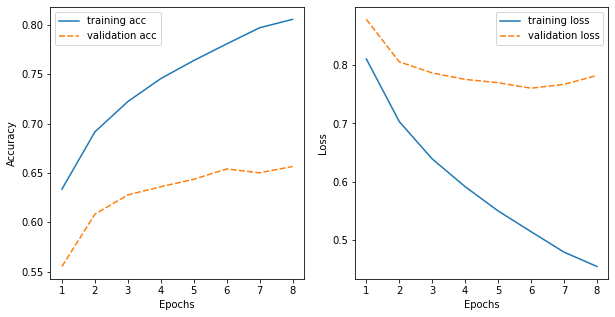

After training model_2_del, the accuracy is 0.6568453699601241
----------------------------------------------------------------------
Start to train model use the data : 3_del
----------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 before training model, the accuracy is 0.3454014383544832
[epoch 1] train_loss: 0.760, train_acc:0.656, val_loss: 0.846, val_acc:0.587
[epoch 2] train_loss: 0.658, train_acc:0.710, val_loss: 0.803, val_acc:0.621
[epoch 3] train_loss: 0.601, train_acc:0.736, val_loss: 0.781, val_acc:0.637
[epoch 4] train_loss: 0.557, train_acc:0.757, val_loss: 0.765, val_acc:0.648
[epoch 5] train_loss: 0.524, train_acc:0.774, val_loss: 0.758, val_acc:0.652
[epoch 6] train_loss: 0.491, train_acc:0.788, val_loss: 0.750, val_acc:0.660
[epoch 7] train_loss: 0.464, train_acc:0.801, val_loss: 0.762, val_acc:0.657
[epoch 8] train_loss: 0.437, train_acc:0.812, val_loss: 0.774, val_acc:0.662
[epoch 9] train_loss: 0.415, train_acc:0.820, val_loss: 0.772, val_acc:0.667


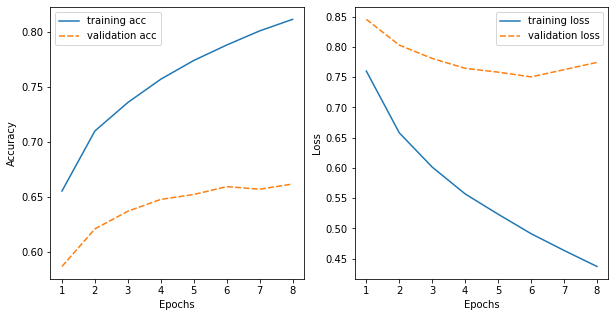

After training model_3_del, the accuracy is 0.6617190961453256
----------------------------------------------------------------------
Start to train model use the data : 4_del
----------------------------------------------------------------------

 before training model, the accuracy is 0.3497680810857241
[epoch 1] train_loss: 0.713, train_acc:0.680, val_loss: 0.833, val_acc:0.591
[epoch 2] train_loss: 0.623, train_acc:0.724, val_loss: 0.803, val_acc:0.617
[epoch 3] train_loss: 0.575, train_acc:0.746, val_loss: 0.785, val_acc:0.634
[epoch 4] train_loss: 0.539, train_acc:0.763, val_loss: 0.788, val_acc:0.643
[epoch 5] train_loss: 0.501, train_acc:0.780, val_loss: 0.749, val_acc:0.658
[epoch 6] train_loss: 0.474, train_acc:0.794, val_loss: 0.740, val_acc:0.660
[epoch 7] train_loss: 0.453, train_acc:0.803, val_loss: 0.754, val_acc:0.663
[epoch 8] train_loss: 0.429, train_acc:0.813, val_loss: 0.745, val_acc:0.665
[epoch 9] train_loss: 0.413, train_acc:0.820, val_loss: 0.761, val_acc:0.669


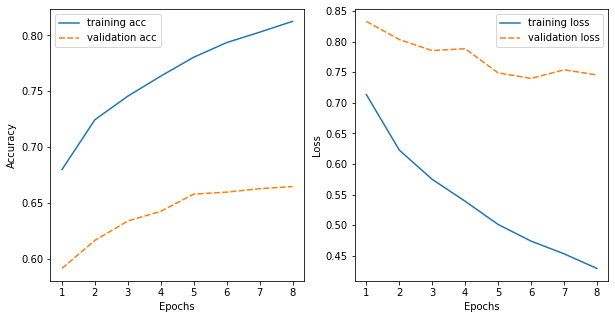

After training model_4_del, the accuracy is 0.6551838723969872
acc_list [0.6910722197607444, 0.6793309703145769, 0.6568453699601241, 0.6617190961453256, 0.6551838723969872]
loss_list [0.6858918480050396, 0.8007107683470551, 0.8011547973458196, 0.787163441239948, 0.7960650794942614]
precision_list [array([0.45681818, 0.66946725, 0.75559534]), array([0.40113798, 0.67086079, 0.75105485]), array([0.30608365, 0.67460494, 0.73987941]), array([0.31467793, 0.67350464, 0.74115942]), array([0.30309498, 0.66631016, 0.73653396])]
recall_list [array([0.2942899 , 0.78733438, 0.65056526]), array([0.41288433, 0.75432293, 0.64028777]), array([0.47144949, 0.68066472, 0.66212744]), array([0.4363104 , 0.70042668, 0.65698869]), array([0.41581259, 0.69952841, 0.64645427])]
fscore_list [array([0.35796972, 0.72363261, 0.69915781]), array([0.40692641, 0.71014799, 0.69126214]), array([0.37118156, 0.67762128, 0.69884746]), array([0.36564417, 0.68670189, 0.69654045]), array([0.35061728, 0.68251534, 0.68856048])]


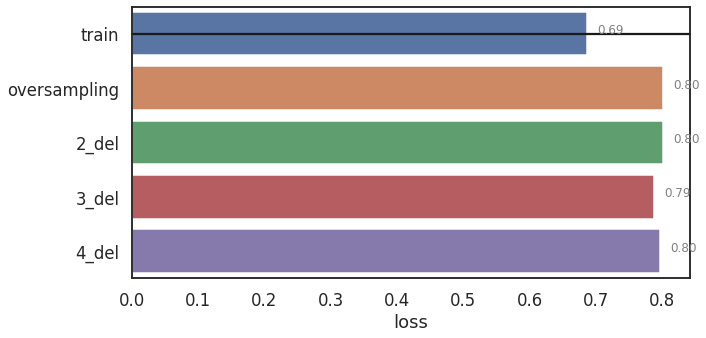

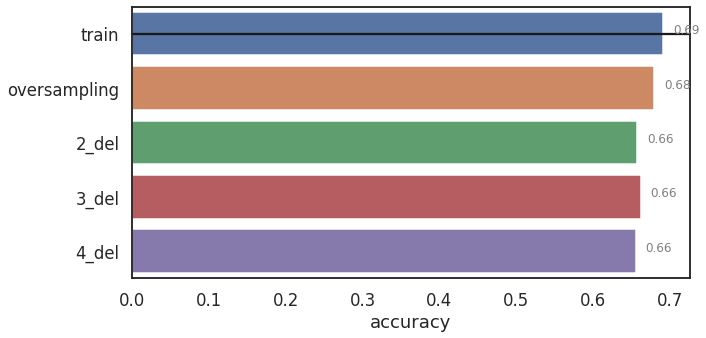

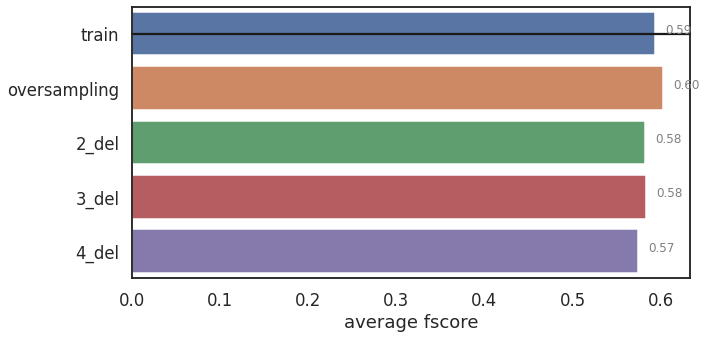

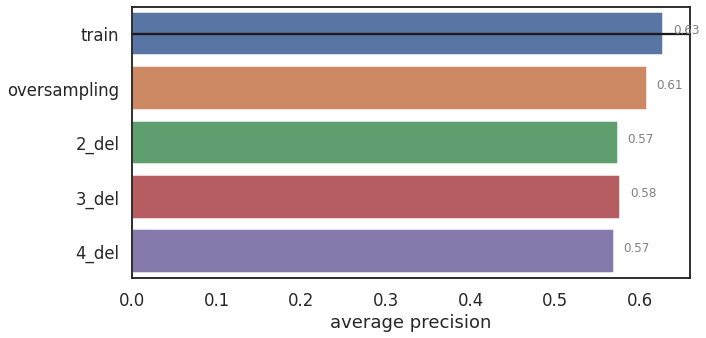

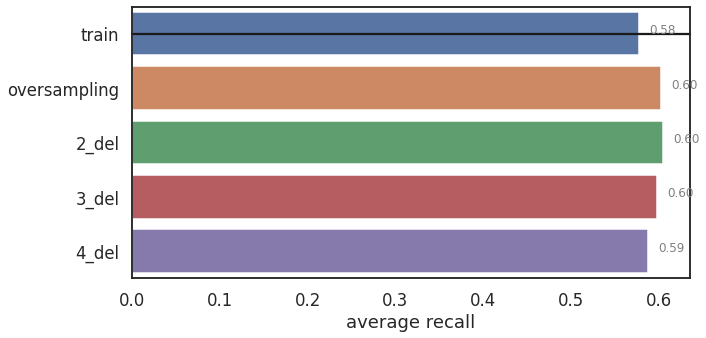

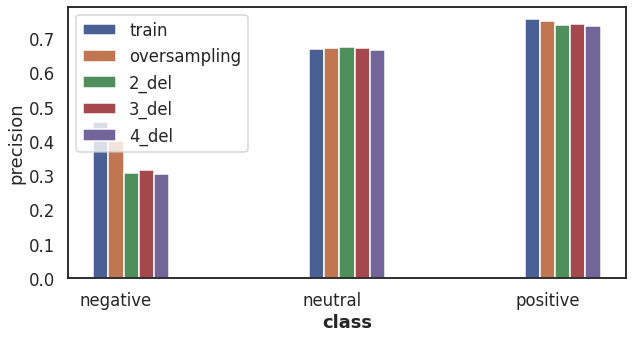

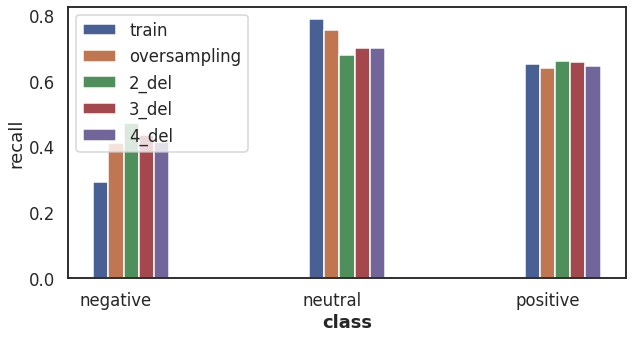

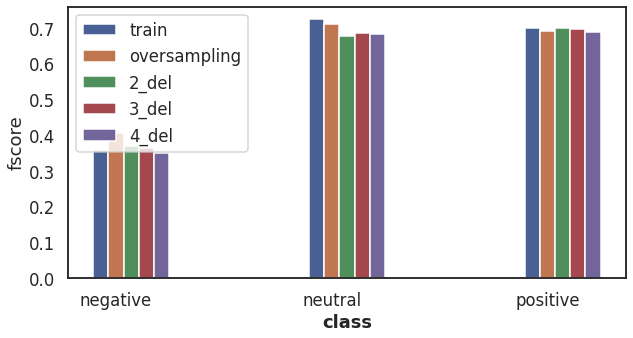

CPU times: user 1h 33min 10s, sys: 30min 1s, total: 2h 3min 11s
Wall time: 2h 3min 17s


In [0]:
%%time
test_list = [
              'train',
              'oversampling',
             '2_del',
             '3_del',
             '4_del',
            #  '5_del',

              ]
              
task_name = 'sub_twitter'
tech_name = 'EDA'

execute(test_list, tech_name, task_name)

### Fasttext aug

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------

 before training model, the accuracy is 0.41848634806381285


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[epoch 1] train_loss: 0.808, train_acc:0.632, val_loss: 0.806, val_acc:0.627
[epoch 2] train_loss: 0.715, train_acc:0.671, val_loss: 0.721, val_acc:0.660
[epoch 3] train_loss: 0.677, train_acc:0.690, val_loss: 0.693, val_acc:0.679
[epoch 4] train_loss: 0.652, train_acc:0.704, val_loss: 0.684, val_acc:0.684
[epoch 5] train_loss: 0.635, train_acc:0.712, val_loss: 0.681, val_acc:0.687
[epoch 6] train_loss: 0.610, train_acc:0.727, val_loss: 0.677, val_acc:0.684
[epoch 7] train_loss: 0.597, train_acc:0.731, val_loss: 0.673, val_acc:0.693
[epoch 8] train_loss: 0.575, train_acc:0.747, val_loss: 0.672, val_acc:0.696
[epoch 9] train_loss: 0.562, train_acc:0.754, val_loss: 0.678, val_acc:0.690
[epoch 10] train_loss: 0.536, train_acc:0.768, val_loss: 0.678, val_acc:0.699
[epoch 11] train_loss: 0.523, train_acc:0.776, val_loss: 0.687, val_acc:0.696


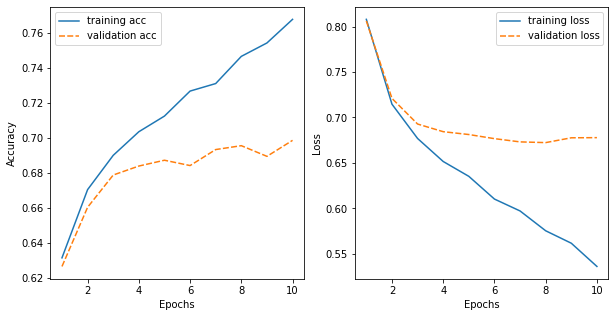

After training model_train, the accuracy is 0.6878599911386797
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------

 before training model, the accuracy is 0.3275484870086773
[epoch 1] train_loss: 0.795, train_acc:0.644, val_loss: 0.888, val_acc:0.570
[epoch 2] train_loss: 0.702, train_acc:0.694, val_loss: 0.808, val_acc:0.610
[epoch 3] train_loss: 0.637, train_acc:0.726, val_loss: 0.771, val_acc:0.636
[epoch 4] train_loss: 0.583, train_acc:0.752, val_loss: 0.781, val_acc:0.634
[epoch 5] train_loss: 0.538, train_acc:0.772, val_loss: 0.746, val_acc:0.660
[epoch 6] train_loss: 0.502, train_acc:0.787, val_loss: 0.760, val_acc:0.655
[epoch 7] train_loss: 0.475, train_acc:0.799, val_loss: 0.745, val_acc:0.677
[epoch 8] train_loss: 0.442, train_acc:0.812, val_loss: 0.753, val_acc:0.674
[epoch 9] train_loss: 0.420, train_acc:0.823, val_loss: 0.763, val_acc

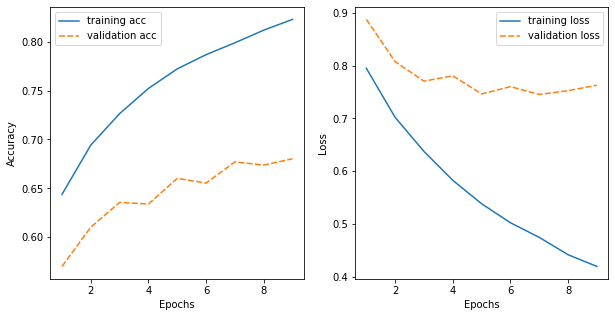

After training model_oversampling, the accuracy is 0.6700265839610102
----------------------------------------------------------------------
Start to train model use the data : 2_rep
----------------------------------------------------------------------

 before training model, the accuracy is 0.31879632593760004
[epoch 1] train_loss: 0.748, train_acc:0.654, val_loss: 0.872, val_acc:0.562
[epoch 2] train_loss: 0.652, train_acc:0.709, val_loss: 0.781, val_acc:0.622
[epoch 3] train_loss: 0.592, train_acc:0.736, val_loss: 0.757, val_acc:0.641
[epoch 4] train_loss: 0.550, train_acc:0.758, val_loss: 0.740, val_acc:0.651
[epoch 5] train_loss: 0.519, train_acc:0.772, val_loss: 0.735, val_acc:0.666
[epoch 6] train_loss: 0.492, train_acc:0.784, val_loss: 0.736, val_acc:0.661
[epoch 7] train_loss: 0.466, train_acc:0.797, val_loss: 0.740, val_acc:0.670
[epoch 8] train_loss: 0.443, train_acc:0.806, val_loss: 0.728, val_acc:0.668
[epoch 9] train_loss: 0.420, train_acc:0.818, val_loss: 0.743, val_ac

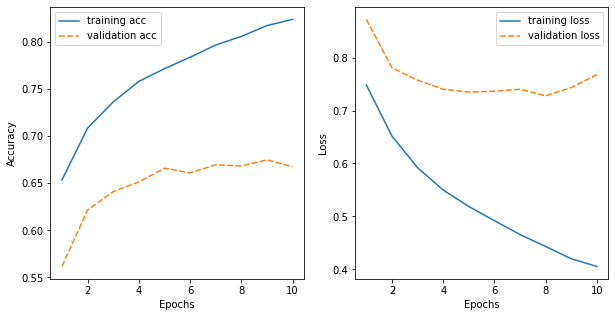

After training model_2_rep, the accuracy is 0.6573992024811697
----------------------------------------------------------------------
Start to train model use the data : 3_rep
----------------------------------------------------------------------

 before training model, the accuracy is 0.34629132053146644
[epoch 1] train_loss: 0.715, train_acc:0.681, val_loss: 0.811, val_acc:0.611
[epoch 2] train_loss: 0.610, train_acc:0.727, val_loss: 0.767, val_acc:0.636
[epoch 3] train_loss: 0.562, train_acc:0.750, val_loss: 0.739, val_acc:0.660
[epoch 4] train_loss: 0.527, train_acc:0.768, val_loss: 0.728, val_acc:0.663
[epoch 5] train_loss: 0.499, train_acc:0.779, val_loss: 0.720, val_acc:0.663
[epoch 6] train_loss: 0.478, train_acc:0.789, val_loss: 0.728, val_acc:0.668
[epoch 7] train_loss: 0.456, train_acc:0.798, val_loss: 0.731, val_acc:0.671
[epoch 8] train_loss: 0.444, train_acc:0.805, val_loss: 0.742, val_acc:0.666


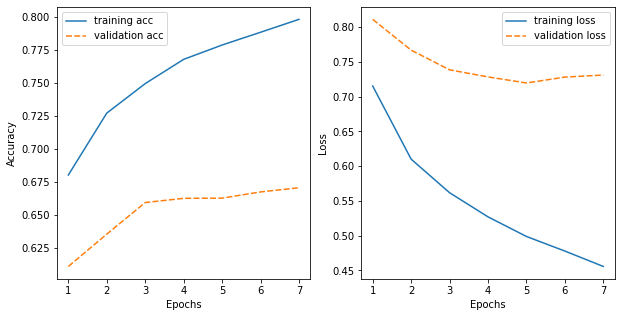

After training model_3_rep, the accuracy is 0.657620735489588
----------------------------------------------------------------------
Start to train model use the data : 4_rep
----------------------------------------------------------------------

 before training model, the accuracy is 0.3139994076414256
[epoch 1] train_loss: 0.676, train_acc:0.701, val_loss: 0.794, val_acc:0.619
[epoch 2] train_loss: 0.588, train_acc:0.739, val_loss: 0.744, val_acc:0.656
[epoch 3] train_loss: 0.544, train_acc:0.762, val_loss: 0.729, val_acc:0.666
[epoch 4] train_loss: 0.515, train_acc:0.773, val_loss: 0.716, val_acc:0.674
[epoch 5] train_loss: 0.492, train_acc:0.784, val_loss: 0.718, val_acc:0.670
[epoch 6] train_loss: 0.472, train_acc:0.793, val_loss: 0.719, val_acc:0.660
[epoch 7] train_loss: 0.450, train_acc:0.803, val_loss: 0.717, val_acc:0.672


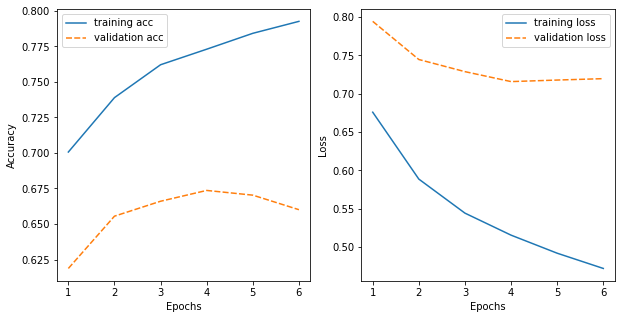

After training model_4_rep, the accuracy is 0.6595037660611431
----------------------------------------------------------------------
Start to train model use the data : 5_rep
----------------------------------------------------------------------

 before training model, the accuracy is 0.34487353485502775
[epoch 1] train_loss: 0.664, train_acc:0.699, val_loss: 0.813, val_acc:0.605
[epoch 2] train_loss: 0.579, train_acc:0.741, val_loss: 0.764, val_acc:0.638
[epoch 3] train_loss: 0.538, train_acc:0.757, val_loss: 0.730, val_acc:0.658
[epoch 4] train_loss: 0.506, train_acc:0.772, val_loss: 0.717, val_acc:0.665
[epoch 5] train_loss: 0.481, train_acc:0.785, val_loss: 0.716, val_acc:0.670
[epoch 6] train_loss: 0.464, train_acc:0.794, val_loss: 0.722, val_acc:0.672
[epoch 7] train_loss: 0.443, train_acc:0.805, val_loss: 0.721, val_acc:0.670
[epoch 8] train_loss: 0.426, train_acc:0.811, val_loss: 0.736, val_acc:0.671


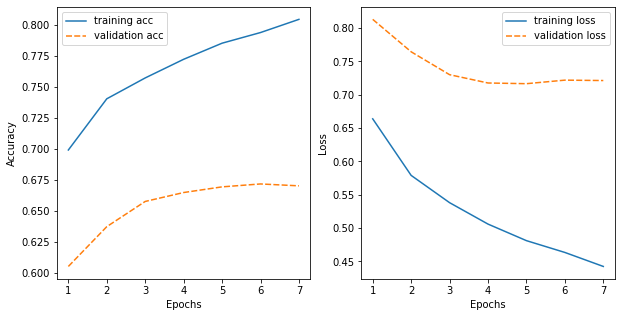

After training model_5_rep, the accuracy is 0.6653743907842269
acc_list [0.6878599911386797, 0.6700265839610102, 0.6573992024811697, 0.657620735489588, 0.6595037660611431, 0.6653743907842269]
loss_list [0.7036042118995962, 0.7914004995369576, 0.8133814145981426, 0.768543305531354, 0.7457879857278206, 0.7565688742718226]
precision_list [array([0.475     , 0.67203456, 0.73472851]), array([0.37693222, 0.65849353, 0.76885724]), array([0.30746562, 0.67305598, 0.74056742]), array([0.31589147, 0.67264378, 0.74057844]), array([0.33851675, 0.66575285, 0.72869565]), array([0.32403433, 0.67883369, 0.73918061])]
recall_list [array([0.27818448, 0.76847069, 0.66752312]), array([0.46412884, 0.75387379, 0.6102261 ]), array([0.45827233, 0.69391422, 0.65056526]), array([0.477306  , 0.69077027, 0.65133607]), array([0.41434846, 0.70896025, 0.64594039]), array([0.44216691, 0.7058163 , 0.65827338])]
fscore_list [array([0.35087719, 0.71702462, 0.69951535]), array([0.4160105 , 0.70296304, 0.68041828]), array(

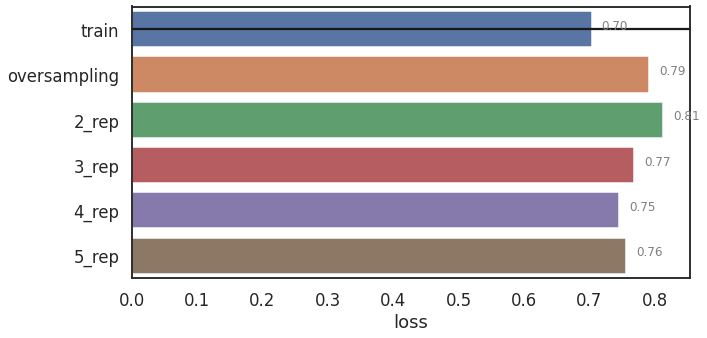

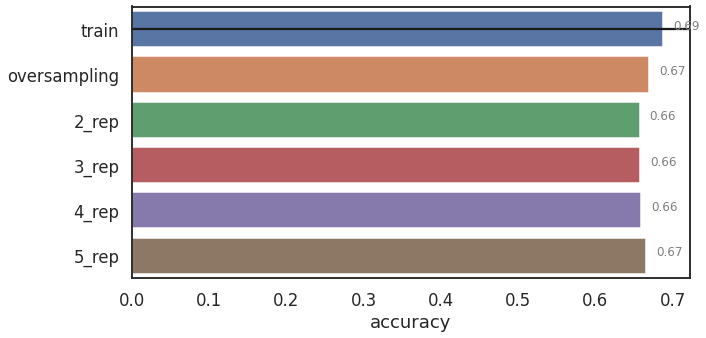

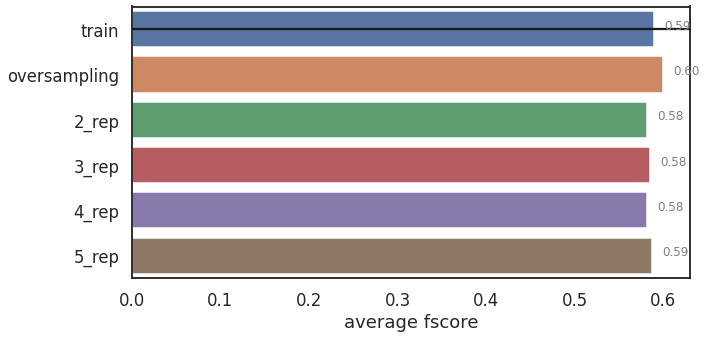

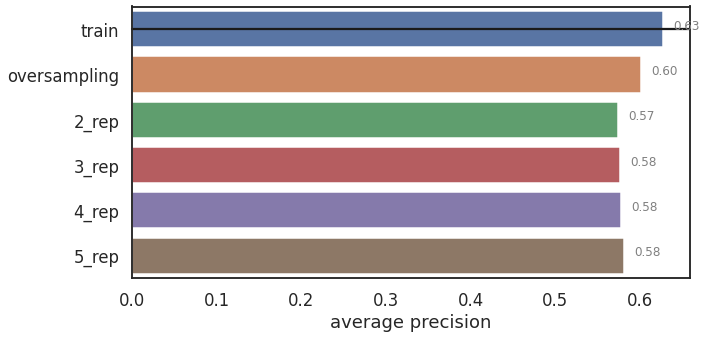

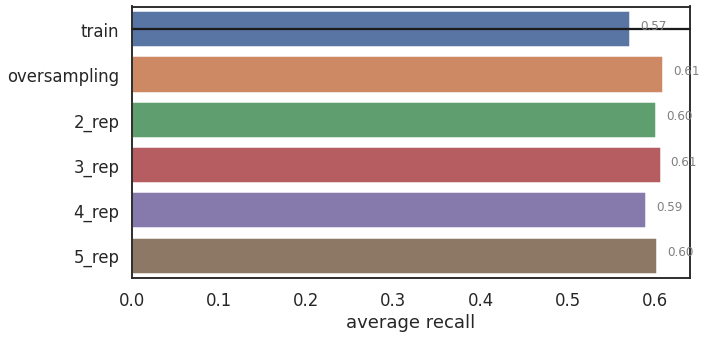

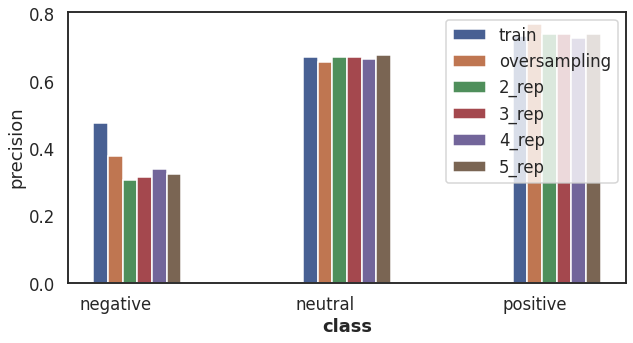

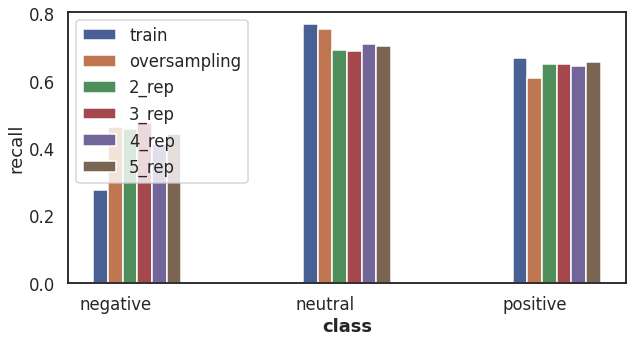

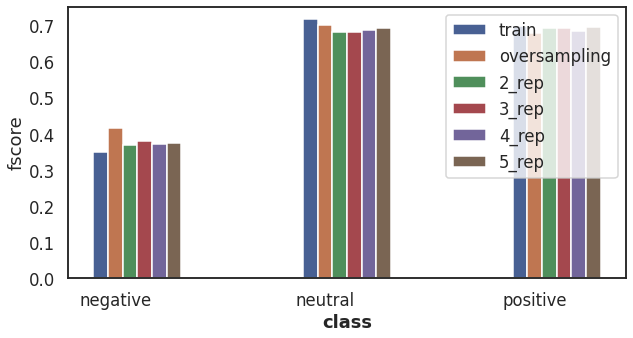

CPU times: user 1h 41min 24s, sys: 40min 32s, total: 2h 21min 56s
Wall time: 2h 22min 10s


In [0]:
%%time
test_list = [
              'train',
              'oversampling',
             '2_rep',
             '3_rep',
             '4_rep',
             '5_rep',
              ]
              
task_name = 'sub_twitter'
tech_name = 'Fasttext_augmentation'

execute(test_list, tech_name, task_name)

### Back translation

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------

 before training model, the accuracy is 0.140187562722774
[epoch 1] train_loss: 0.808, train_acc:0.630, val_loss: 0.806, val_acc:0.629
[epoch 2] train_loss: 0.714, train_acc:0.672, val_loss: 0.723, val_acc:0.667
[epoch 3] train_loss: 0.679, train_acc:0.687, val_loss: 0.696, val_acc:0.681
[epoch 4] train_loss: 0.652, train_acc:0.705, val_loss: 0.685, val_acc:0.681
[epoch 5] train_loss: 0.629, train_acc:0.715, val_loss: 0.676, val_acc:0.691
[epoch 6] train_loss: 0.614, train_acc:0.725, val_loss: 0.676, val_acc:0.690
[epoch 7] train_loss: 0.596, train_acc:0.734, val_loss: 0.678, val_acc:0.687
[epoch 8] train_loss: 0.576, train_acc:0.744, val_loss: 0.666, val_acc:0.695
[epoch 9] train_loss: 0.563, train_acc:0.755, val_loss: 0.672, val_acc:0.693
[epoch 10] train_loss: 0.544, train_acc:0.763, val_loss: 0.680, 

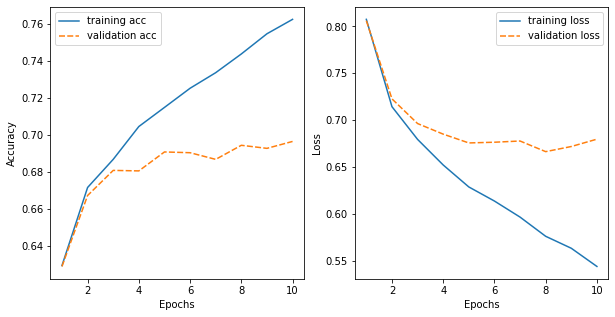

After training model_train, the accuracy is 0.6863092600797519
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------

 before training model, the accuracy is 0.31378284702932574
[epoch 1] train_loss: 0.803, train_acc:0.641, val_loss: 0.882, val_acc:0.570
[epoch 2] train_loss: 0.695, train_acc:0.696, val_loss: 0.821, val_acc:0.603
[epoch 3] train_loss: 0.629, train_acc:0.728, val_loss: 0.780, val_acc:0.628
[epoch 4] train_loss: 0.579, train_acc:0.749, val_loss: 0.752, val_acc:0.651
[epoch 5] train_loss: 0.533, train_acc:0.771, val_loss: 0.743, val_acc:0.661
[epoch 6] train_loss: 0.496, train_acc:0.787, val_loss: 0.744, val_acc:0.664
[epoch 7] train_loss: 0.456, train_acc:0.807, val_loss: 0.760, val_acc:0.673
[epoch 8] train_loss: 0.443, train_acc:0.809, val_loss: 0.753, val_acc:0.678


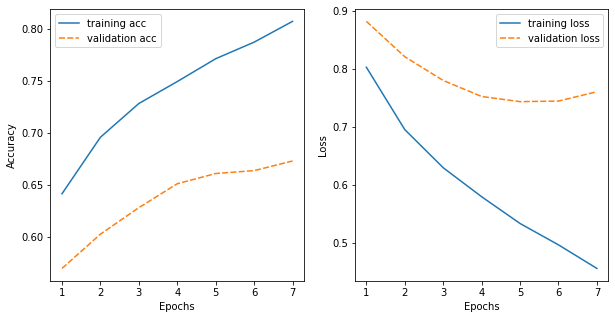

After training model_oversampling, the accuracy is 0.6737926451041205
----------------------------------------------------------------------
Start to train model use the data : negative_aug
----------------------------------------------------------------------

 before training model, the accuracy is 0.3413506467955339
[epoch 1] train_loss: 0.718, train_acc:0.668, val_loss: 0.842, val_acc:0.586
[epoch 2] train_loss: 0.632, train_acc:0.716, val_loss: 0.788, val_acc:0.625
[epoch 3] train_loss: 0.587, train_acc:0.739, val_loss: 0.757, val_acc:0.637
[epoch 4] train_loss: 0.554, train_acc:0.756, val_loss: 0.741, val_acc:0.648
[epoch 5] train_loss: 0.526, train_acc:0.770, val_loss: 0.728, val_acc:0.656
[epoch 6] train_loss: 0.504, train_acc:0.779, val_loss: 0.741, val_acc:0.653
[epoch 7] train_loss: 0.479, train_acc:0.791, val_loss: 0.743, val_acc:0.662
[epoch 8] train_loss: 0.454, train_acc:0.805, val_loss: 0.731, val_acc:0.661


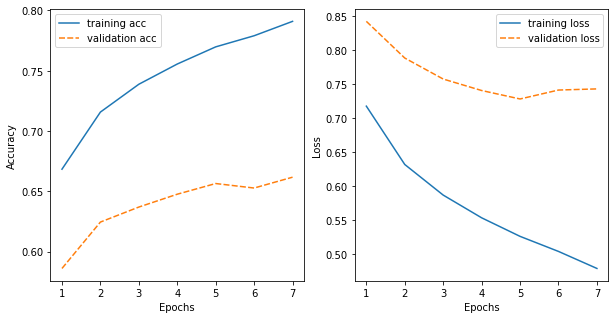

After training model_negative_aug, the accuracy is 0.6575099689853788
acc_list [0.6863092600797519, 0.6737926451041205, 0.6575099689853788]
loss_list [0.6971911817369326, 0.765557027198899, 0.7519442376116632]
precision_list [array([0.46846847, 0.67261551, 0.73312624]), array([0.37581274, 0.66366131, 0.76274945]), array([0.32395732, 0.68579361, 0.71782313])]
recall_list [array([0.3045388 , 0.76173366, 0.66700925]), array([0.42313324, 0.76038626, 0.61870504]), array([0.48901903, 0.66561868, 0.67780062])]
fscore_list [array([0.36912156, 0.71440607, 0.69850666]), array([0.39807163, 0.70873888, 0.68321748]), array([0.38973162, 0.67555556, 0.69723801])]
average prec [0.6247367368793424, 0.6007411662632988, 0.5758580221022176]
average recall [0.577760570618905, 0.6007415093840961, 0.6108127781192456]
average fs [0.5940114289571604, 0.5966759943894031, 0.5875083948762648]


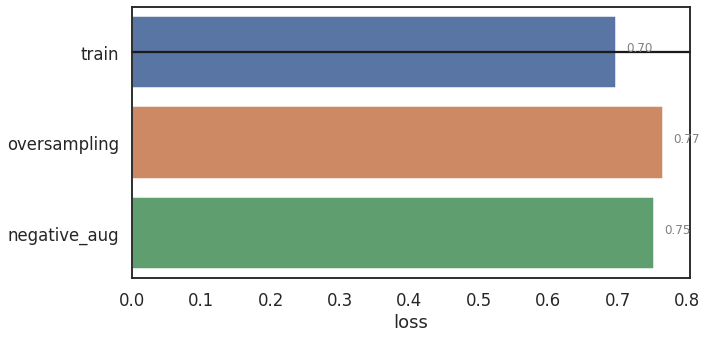

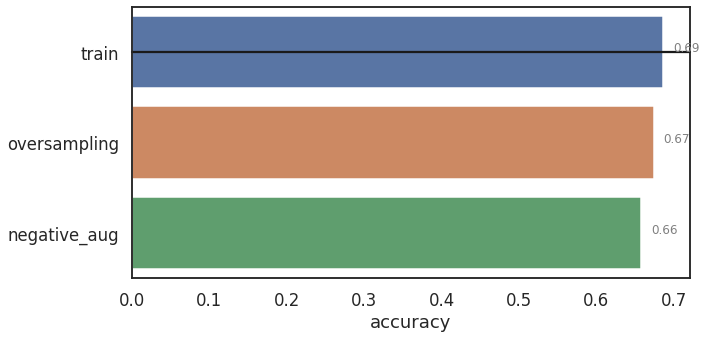

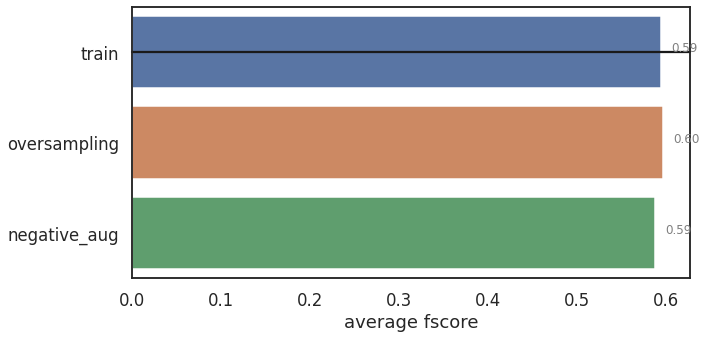

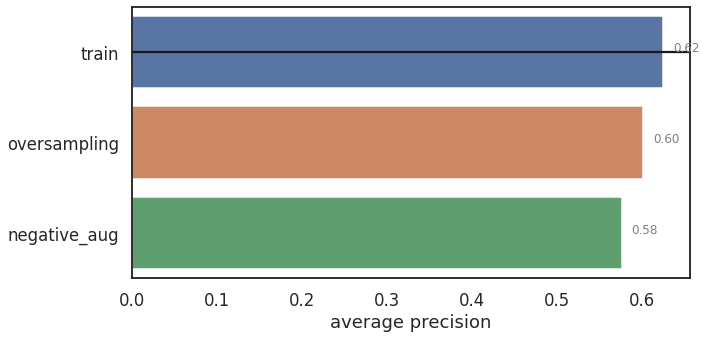

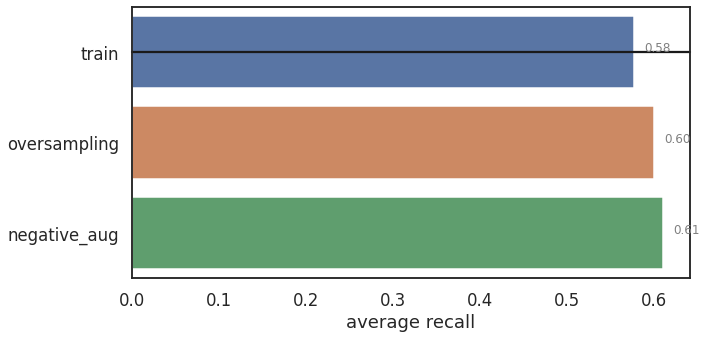

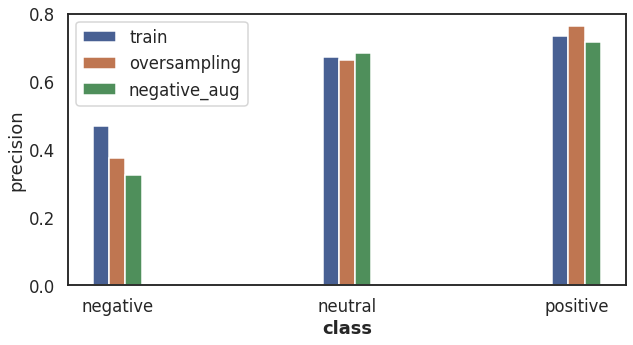

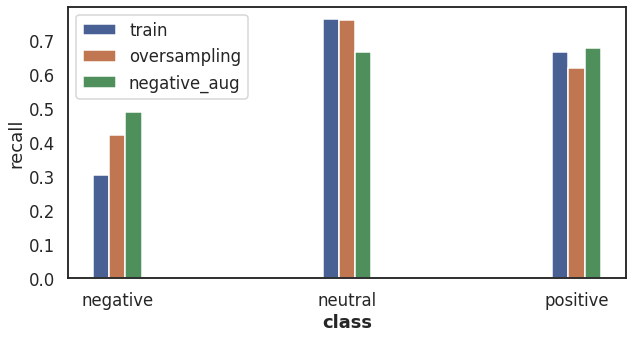

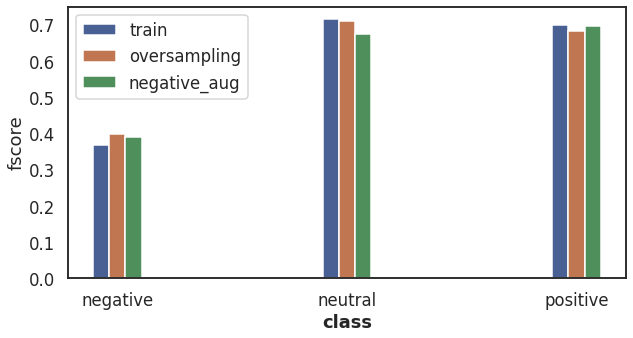

CPU times: user 46min 48s, sys: 18min 7s, total: 1h 4min 55s
Wall time: 1h 4min 59s


In [10]:
%%time
test_list = [
              'train',
              'oversampling',
             'negative_aug'
              ]
              
task_name = 'sub_twitter'
tech_name = 'Back_trans'

execute(test_list, tech_name, task_name)

### BERT

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------

 before training model, the accuracy is 0.3279233138388068


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[epoch 1] train_loss: 0.798, train_acc:0.638, val_loss: 0.799, val_acc:0.628
[epoch 2] train_loss: 0.706, train_acc:0.679, val_loss: 0.717, val_acc:0.663
[epoch 3] train_loss: 0.669, train_acc:0.697, val_loss: 0.689, val_acc:0.680
[epoch 4] train_loss: 0.645, train_acc:0.710, val_loss: 0.681, val_acc:0.684
[epoch 5] train_loss: 0.624, train_acc:0.720, val_loss: 0.675, val_acc:0.689
[epoch 6] train_loss: 0.602, train_acc:0.732, val_loss: 0.667, val_acc:0.691
[epoch 7] train_loss: 0.585, train_acc:0.739, val_loss: 0.668, val_acc:0.698
[epoch 8] train_loss: 0.570, train_acc:0.746, val_loss: 0.663, val_acc:0.700
[epoch 9] train_loss: 0.550, train_acc:0.758, val_loss: 0.671, val_acc:0.693
[epoch 10] train_loss: 0.533, train_acc:0.768, val_loss: 0.669, val_acc:0.702
[epoch 11] train_loss: 0.516, train_acc:0.777, val_loss: 0.677, val_acc:0.698


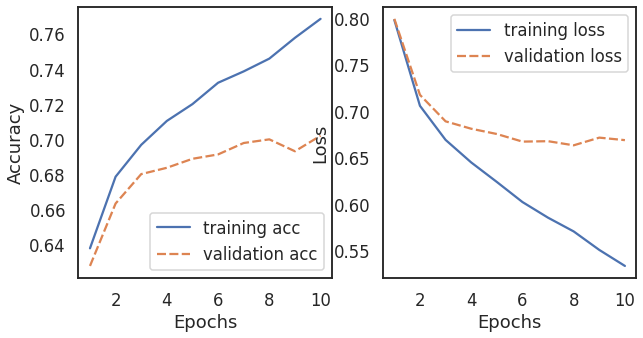

After training model_train, the accuracy is 0.6854231280460789
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------

 before training model, the accuracy is 0.3449276074826086
[epoch 1] train_loss: 0.828, train_acc:0.630, val_loss: 0.898, val_acc:0.552
[epoch 2] train_loss: 0.706, train_acc:0.693, val_loss: 0.802, val_acc:0.612
[epoch 3] train_loss: 0.639, train_acc:0.725, val_loss: 0.775, val_acc:0.630
[epoch 4] train_loss: 0.583, train_acc:0.752, val_loss: 0.763, val_acc:0.642
[epoch 5] train_loss: 0.538, train_acc:0.771, val_loss: 0.741, val_acc:0.657
[epoch 6] train_loss: 0.501, train_acc:0.787, val_loss: 0.745, val_acc:0.665
[epoch 7] train_loss: 0.465, train_acc:0.802, val_loss: 0.772, val_acc:0.665
[epoch 8] train_loss: 0.438, train_acc:0.813, val_loss: 0.773, val_acc:0.672


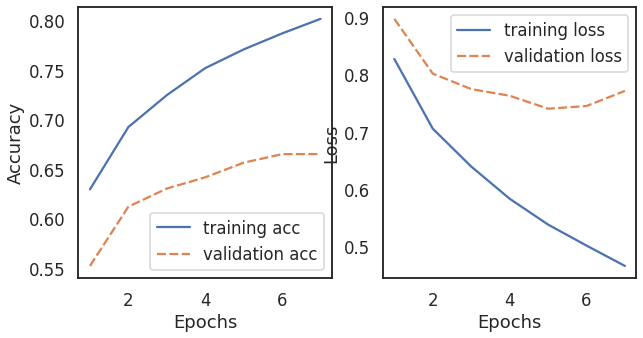

After training model_oversampling, the accuracy is 0.660279131590607
----------------------------------------------------------------------
Start to train model use the data : 2_rep_(unfine)
----------------------------------------------------------------------

 before training model, the accuracy is 0.3474611627849903
[epoch 1] train_loss: 0.764, train_acc:0.659, val_loss: 0.836, val_acc:0.600
[epoch 2] train_loss: 0.661, train_acc:0.710, val_loss: 0.788, val_acc:0.631
[epoch 3] train_loss: 0.602, train_acc:0.735, val_loss: 0.758, val_acc:0.645
[epoch 4] train_loss: 0.557, train_acc:0.758, val_loss: 0.761, val_acc:0.645
[epoch 5] train_loss: 0.518, train_acc:0.775, val_loss: 0.743, val_acc:0.657
[epoch 6] train_loss: 0.493, train_acc:0.787, val_loss: 0.747, val_acc:0.657
[epoch 7] train_loss: 0.465, train_acc:0.799, val_loss: 0.743, val_acc:0.667
[epoch 8] train_loss: 0.443, train_acc:0.807, val_loss: 0.766, val_acc:0.662
[epoch 9] train_loss: 0.423, train_acc:0.818, val_loss: 0.740,

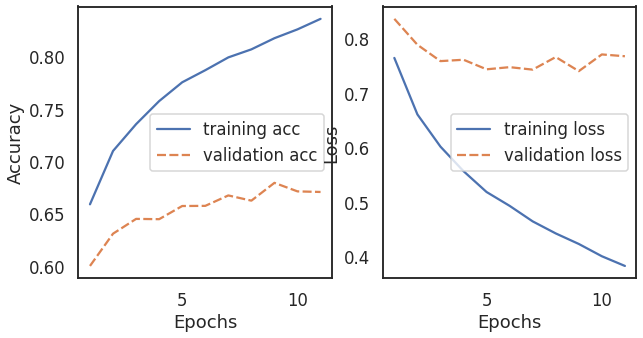

After training model_2_rep_(unfine), the accuracy is 0.6592822330527248
----------------------------------------------------------------------
Start to train model use the data : 3_rep_(unfine)
----------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 before training model, the accuracy is 0.3105259282891992
[epoch 1] train_loss: 0.755, train_acc:0.651, val_loss: 0.865, val_acc:0.569
[epoch 2] train_loss: 0.648, train_acc:0.711, val_loss: 0.789, val_acc:0.627
[epoch 3] train_loss: 0.586, train_acc:0.743, val_loss: 0.755, val_acc:0.651
[epoch 4] train_loss: 0.547, train_acc:0.758, val_loss: 0.741, val_acc:0.655
[epoch 5] train_loss: 0.512, train_acc:0.776, val_loss: 0.732, val_acc:0.662
[epoch 6] train_loss: 0.483, train_acc:0.789, val_loss: 0.745, val_acc:0.658
[epoch 7] train_loss: 0.464, train_acc:0.798, val_loss: 0.734, val_acc:0.670
[epoch 8] train_loss: 0.440, train_acc:0.809, val_loss: 0.740, val_acc:0.667


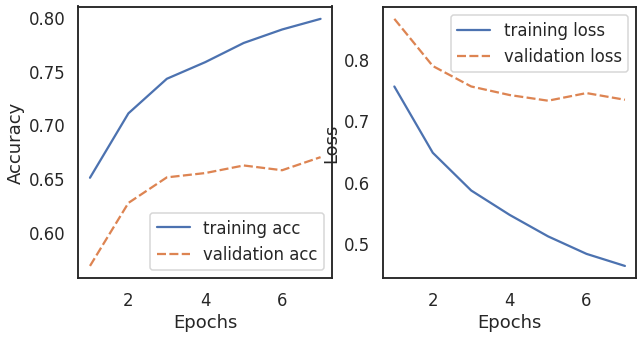

After training model_3_rep_(unfine), the accuracy is 0.6565130704474966
----------------------------------------------------------------------
Start to train model use the data : 4_rep_(unfine)
----------------------------------------------------------------------

 before training model, the accuracy is 0.3469948707880335
[epoch 1] train_loss: 0.731, train_acc:0.662, val_loss: 0.843, val_acc:0.577
[epoch 2] train_loss: 0.609, train_acc:0.727, val_loss: 0.771, val_acc:0.631
[epoch 3] train_loss: 0.557, train_acc:0.751, val_loss: 0.735, val_acc:0.658
[epoch 4] train_loss: 0.518, train_acc:0.769, val_loss: 0.730, val_acc:0.660
[epoch 5] train_loss: 0.489, train_acc:0.783, val_loss: 0.717, val_acc:0.673
[epoch 6] train_loss: 0.468, train_acc:0.793, val_loss: 0.719, val_acc:0.675
[epoch 7] train_loss: 0.447, train_acc:0.804, val_loss: 0.734, val_acc:0.665
[epoch 8] train_loss: 0.429, train_acc:0.812, val_loss: 0.715, val_acc:0.678
[epoch 9] train_loss: 0.410, train_acc:0.822, val_loss: 0.7

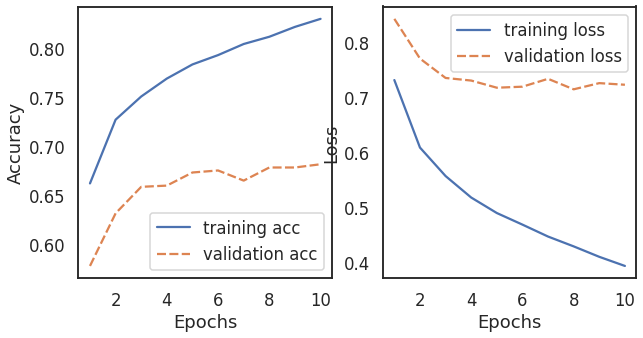

After training model_4_rep_(unfine), the accuracy is 0.6614975631369074
----------------------------------------------------------------------
Start to train model use the data : 5_rep_(unfine)
----------------------------------------------------------------------

 before training model, the accuracy is 0.32208506147691857
[epoch 1] train_loss: 0.740, train_acc:0.654, val_loss: 0.873, val_acc:0.561
[epoch 2] train_loss: 0.622, train_acc:0.715, val_loss: 0.784, val_acc:0.622
[epoch 3] train_loss: 0.556, train_acc:0.748, val_loss: 0.752, val_acc:0.648
[epoch 4] train_loss: 0.517, train_acc:0.768, val_loss: 0.739, val_acc:0.653
[epoch 5] train_loss: 0.491, train_acc:0.780, val_loss: 0.724, val_acc:0.663
[epoch 6] train_loss: 0.468, train_acc:0.791, val_loss: 0.725, val_acc:0.664
[epoch 7] train_loss: 0.448, train_acc:0.799, val_loss: 0.724, val_acc:0.668
[epoch 8] train_loss: 0.427, train_acc:0.812, val_loss: 0.717, val_acc:0.670
[epoch 9] train_loss: 0.415, train_acc:0.817, val_loss: 0.

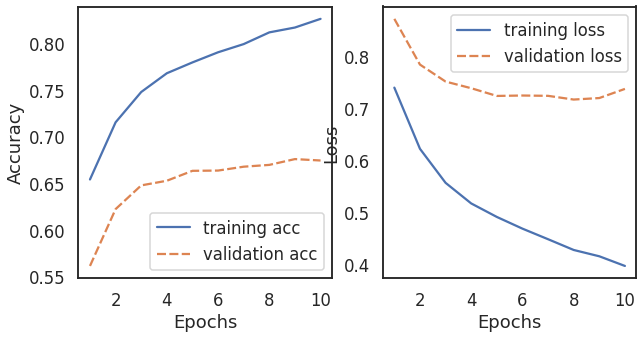

After training model_5_rep_(unfine), the accuracy is 0.675897208684094
acc_list [0.6854231280460789, 0.660279131590607, 0.6592822330527248, 0.6565130704474966, 0.6614975631369074, 0.675897208684094]
loss_list [0.6960930799094724, 0.7990935959026847, 0.826428718340229, 0.7725285933890813, 0.7753550494220894, 0.7508527892576137]
precision_list [array([0.46756152, 0.67341214, 0.72924791]), array([0.33212996, 0.66937033, 0.75950541]), array([0.30522946, 0.66851773, 0.74391317]), array([0.31168831, 0.68010936, 0.71440108]), array([0.3297619 , 0.67480748, 0.72138348]), array([0.375     , 0.67926933, 0.72391304])]
recall_list [array([0.30600293, 0.75477206, 0.67266187]), array([0.53879941, 0.70424433, 0.63129496]), array([0.41874085, 0.70289692, 0.65159301]), array([0.42166911, 0.67033461, 0.68191161]), array([0.40556369, 0.68874916, 0.67523124]), array([0.35139092, 0.71816753, 0.68448099])]
fscore_list [array([0.3699115 , 0.71177467, 0.69981288]), array([0.41094361, 0.68636463, 0.68949067]),

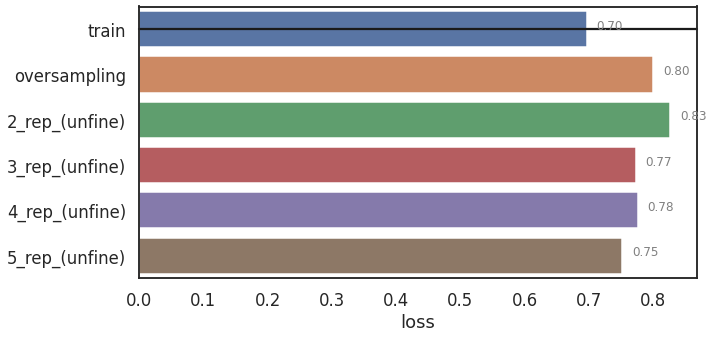

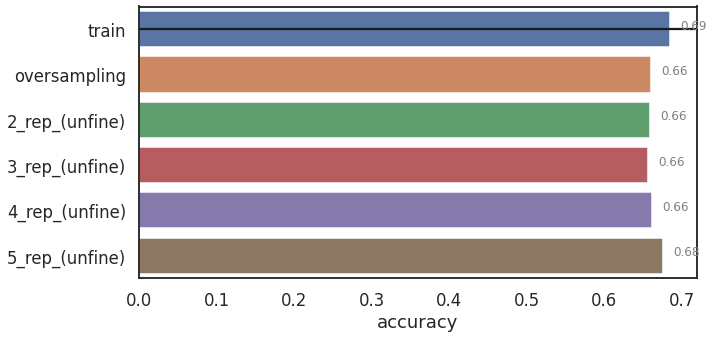

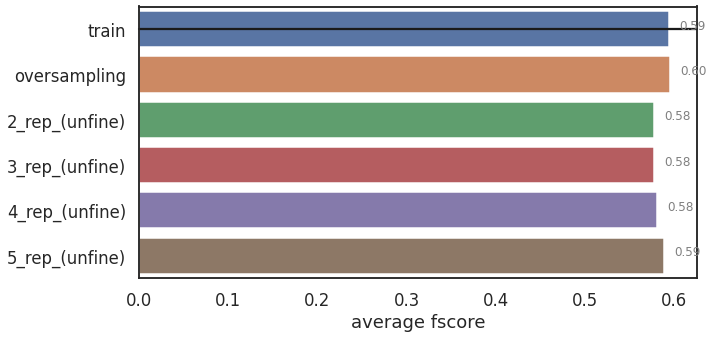

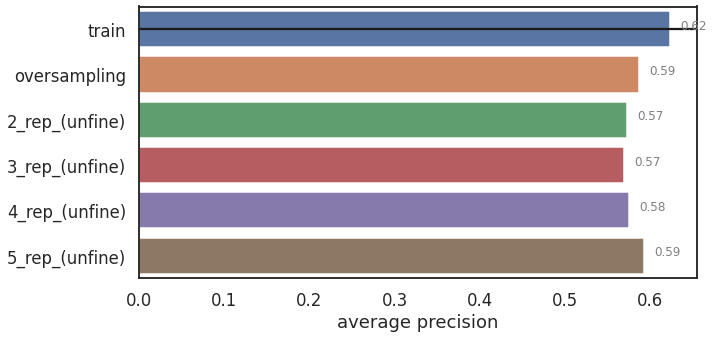

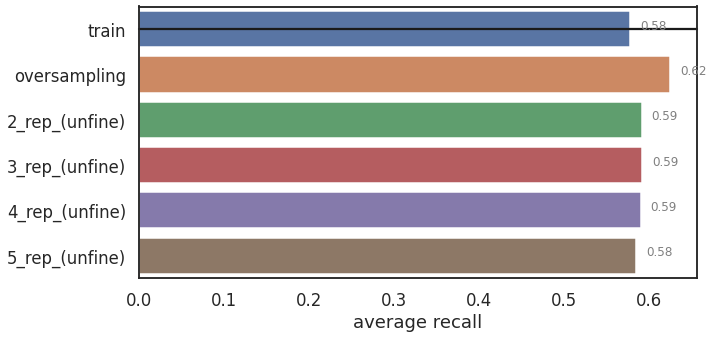

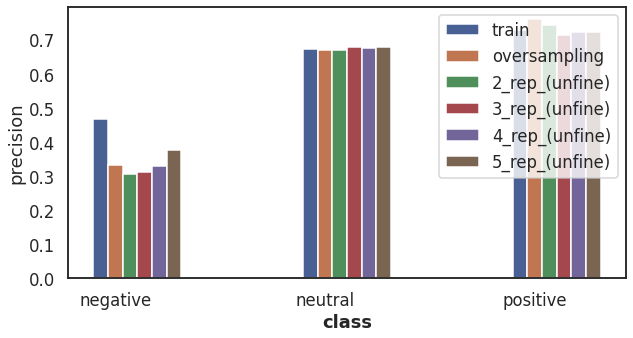

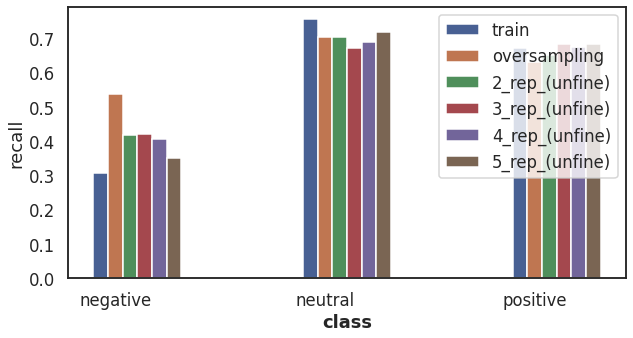

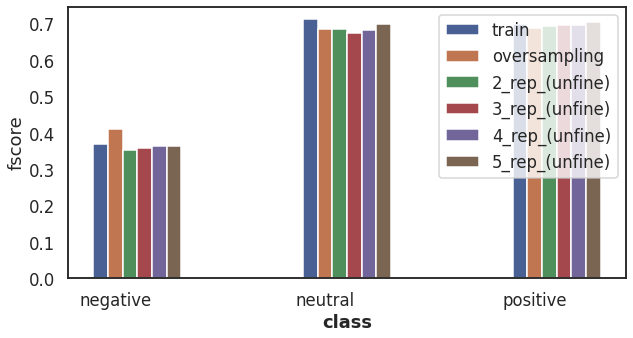

CPU times: user 1h 50min 40s, sys: 43min 46s, total: 2h 34min 27s
Wall time: 2h 34min 31s


In [12]:
%%time
test_list = [
              'train',
              'oversampling',
              '2_rep_(unfine)',
              '3_rep_(unfine)',
              '4_rep_(unfine)',
              '5_rep_(unfine)',
              # '6_rep_(unfine)'
              ]
              
task_name = 'sub_twitter'
tech_name = 'Bert_ data augmentation-master'

execute(test_list, tech_name, task_name)

### BERT Finetune 

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------

 before training model, the accuracy is 0.48548292210264044


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[epoch 1] train_loss: 0.822, train_acc:0.620, val_loss: 0.816, val_acc:0.616
[epoch 2] train_loss: 0.727, train_acc:0.669, val_loss: 0.732, val_acc:0.659
[epoch 3] train_loss: 0.679, train_acc:0.689, val_loss: 0.696, val_acc:0.679
[epoch 4] train_loss: 0.651, train_acc:0.705, val_loss: 0.685, val_acc:0.684
[epoch 5] train_loss: 0.634, train_acc:0.711, val_loss: 0.679, val_acc:0.686
[epoch 6] train_loss: 0.613, train_acc:0.728, val_loss: 0.672, val_acc:0.695
[epoch 7] train_loss: 0.597, train_acc:0.734, val_loss: 0.673, val_acc:0.693
[epoch 8] train_loss: 0.578, train_acc:0.743, val_loss: 0.671, val_acc:0.693
[epoch 9] train_loss: 0.562, train_acc:0.752, val_loss: 0.669, val_acc:0.694
[epoch 10] train_loss: 0.544, train_acc:0.762, val_loss: 0.683, val_acc:0.694
[epoch 11] train_loss: 0.526, train_acc:0.771, val_loss: 0.682, val_acc:0.691
[epoch 12] train_loss: 0.506, train_acc:0.783, val_loss: 0.685, val_acc:0.696


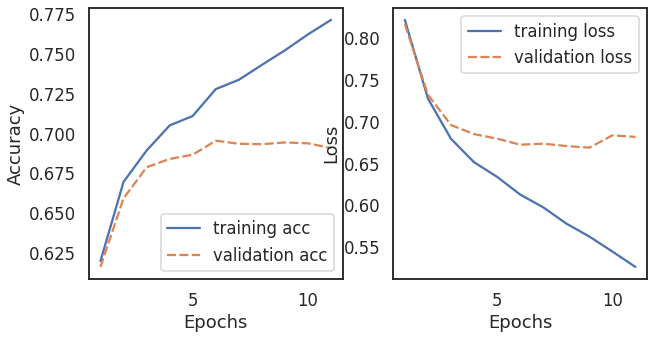

After training model_train, the accuracy is 0.6868630926007975
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------

 before training model, the accuracy is 0.3549076964676385
[epoch 1] train_loss: 0.771, train_acc:0.659, val_loss: 0.865, val_acc:0.576
[epoch 2] train_loss: 0.684, train_acc:0.704, val_loss: 0.811, val_acc:0.611
[epoch 3] train_loss: 0.623, train_acc:0.732, val_loss: 0.789, val_acc:0.631
[epoch 4] train_loss: 0.572, train_acc:0.757, val_loss: 0.749, val_acc:0.651
[epoch 5] train_loss: 0.528, train_acc:0.777, val_loss: 0.753, val_acc:0.662
[epoch 6] train_loss: 0.490, train_acc:0.791, val_loss: 0.750, val_acc:0.664
[epoch 7] train_loss: 0.462, train_acc:0.804, val_loss: 0.750, val_acc:0.673


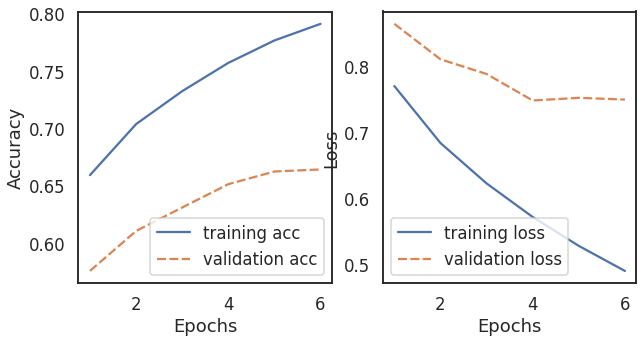

After training model_oversampling, the accuracy is 0.6650420912715995
----------------------------------------------------------------------
Start to train model use the data : 2_rep_(tuned)
----------------------------------------------------------------------

 before training model, the accuracy is 0.34726482931258745
[epoch 1] train_loss: 0.813, train_acc:0.627, val_loss: 0.864, val_acc:0.566
[epoch 2] train_loss: 0.707, train_acc:0.688, val_loss: 0.852, val_acc:0.592
[epoch 3] train_loss: 0.649, train_acc:0.715, val_loss: 0.815, val_acc:0.616
[epoch 4] train_loss: 0.600, train_acc:0.744, val_loss: 0.792, val_acc:0.633
[epoch 5] train_loss: 0.565, train_acc:0.758, val_loss: 0.756, val_acc:0.653
[epoch 6] train_loss: 0.530, train_acc:0.775, val_loss: 0.762, val_acc:0.654
[epoch 7] train_loss: 0.498, train_acc:0.789, val_loss: 0.775, val_acc:0.653
[epoch 8] train_loss: 0.476, train_acc:0.798, val_loss: 0.785, val_acc:0.653


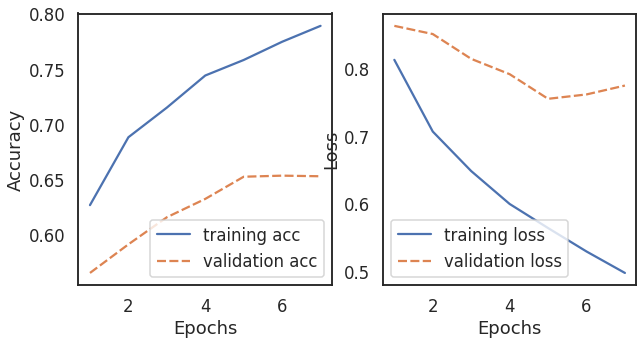

After training model_2_rep_(tuned), the accuracy is 0.650753212228622
----------------------------------------------------------------------
Start to train model use the data : 3_rep_(tuned)
----------------------------------------------------------------------

 before training model, the accuracy is 0.3482219549905515
[epoch 1] train_loss: 0.799, train_acc:0.635, val_loss: 0.890, val_acc:0.550
[epoch 2] train_loss: 0.691, train_acc:0.696, val_loss: 0.826, val_acc:0.606
[epoch 3] train_loss: 0.630, train_acc:0.728, val_loss: 0.794, val_acc:0.630
[epoch 4] train_loss: 0.585, train_acc:0.749, val_loss: 0.773, val_acc:0.639
[epoch 5] train_loss: 0.548, train_acc:0.765, val_loss: 0.752, val_acc:0.656
[epoch 6] train_loss: 0.515, train_acc:0.781, val_loss: 0.749, val_acc:0.664
[epoch 7] train_loss: 0.490, train_acc:0.790, val_loss: 0.759, val_acc:0.656
[epoch 8] train_loss: 0.467, train_acc:0.800, val_loss: 0.762, val_acc:0.661
[epoch 9] train_loss: 0.446, train_acc:0.809, val_loss: 0.775,

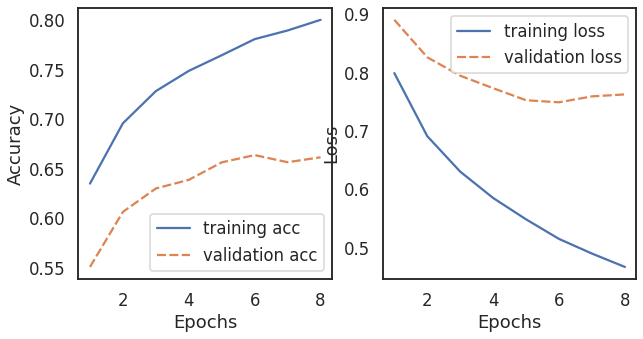

After training model_3_rep_(tuned), the accuracy is 0.6477625166149756
----------------------------------------------------------------------
Start to train model use the data : 4_rep_(tuned)
----------------------------------------------------------------------

 before training model, the accuracy is 0.3484919135151054
[epoch 1] train_loss: 0.749, train_acc:0.662, val_loss: 0.849, val_acc:0.589
[epoch 2] train_loss: 0.646, train_acc:0.715, val_loss: 0.786, val_acc:0.623
[epoch 3] train_loss: 0.596, train_acc:0.741, val_loss: 0.771, val_acc:0.645
[epoch 4] train_loss: 0.558, train_acc:0.757, val_loss: 0.752, val_acc:0.654
[epoch 5] train_loss: 0.530, train_acc:0.771, val_loss: 0.740, val_acc:0.660
[epoch 6] train_loss: 0.501, train_acc:0.783, val_loss: 0.740, val_acc:0.665
[epoch 7] train_loss: 0.479, train_acc:0.795, val_loss: 0.714, val_acc:0.682
[epoch 8] train_loss: 0.456, train_acc:0.804, val_loss: 0.727, val_acc:0.669
[epoch 9] train_loss: 0.441, train_acc:0.812, val_loss: 0.723

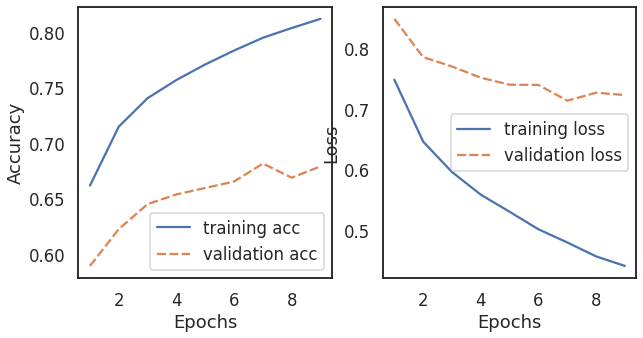

After training model_4_rep_(tuned), the accuracy is 0.66371289322109
----------------------------------------------------------------------
Start to train model use the data : 5_rep_(tuned)
----------------------------------------------------------------------

 before training model, the accuracy is 0.30618205021228556
[epoch 1] train_loss: 0.757, train_acc:0.656, val_loss: 0.872, val_acc:0.589
[epoch 2] train_loss: 0.650, train_acc:0.713, val_loss: 0.787, val_acc:0.632
[epoch 3] train_loss: 0.596, train_acc:0.737, val_loss: 0.761, val_acc:0.646
[epoch 4] train_loss: 0.556, train_acc:0.757, val_loss: 0.739, val_acc:0.659
[epoch 5] train_loss: 0.523, train_acc:0.771, val_loss: 0.726, val_acc:0.668
[epoch 6] train_loss: 0.496, train_acc:0.784, val_loss: 0.723, val_acc:0.673
[epoch 7] train_loss: 0.470, train_acc:0.796, val_loss: 0.721, val_acc:0.672
[epoch 8] train_loss: 0.447, train_acc:0.808, val_loss: 0.726, val_acc:0.672
[epoch 9] train_loss: 0.426, train_acc:0.816, val_loss: 0.739,

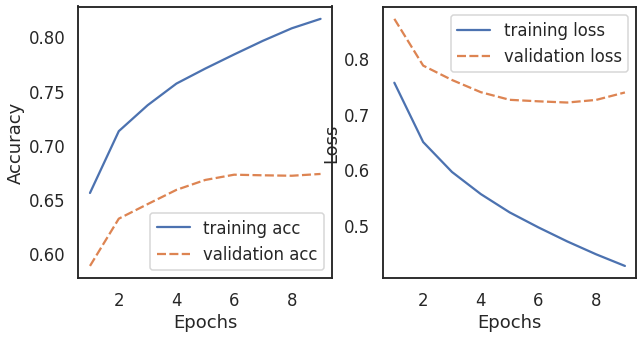

After training model_5_rep_(tuned), the accuracy is 0.6655959237926451
acc_list [0.6868630926007975, 0.6650420912715995, 0.650753212228622, 0.6477625166149756, 0.66371289322109, 0.6655959237926451]
loss_list [0.7104351583500983, 0.7667048271273224, 0.7977831017383388, 0.7996492553764666, 0.7612123802094393, 0.7577334818705707]
precision_list [array([0.47306792, 0.67130537, 0.73563875]), array([0.35654886, 0.66846026, 0.75170068]), array([0.2993311 , 0.67544248, 0.74396135]), array([0.29856115, 0.67269884, 0.72819767]), array([0.34508076, 0.67281406, 0.7105404 ]), array([0.34525447, 0.67009876, 0.72529644])]
recall_list [array([0.29575403, 0.7691444 , 0.66135663]), array([0.50219619, 0.72535369, 0.62461459]), array([0.52415813, 0.68560521, 0.63309353]), array([0.48609078, 0.67617337, 0.64362795]), array([0.34407028, 0.69638446, 0.68242549]), array([0.36749634, 0.71614642, 0.66007194])]
fscore_list [array([0.36396396, 0.71690215, 0.6965228 ]), array([0.41702128, 0.69574583, 0.6822902 ]),

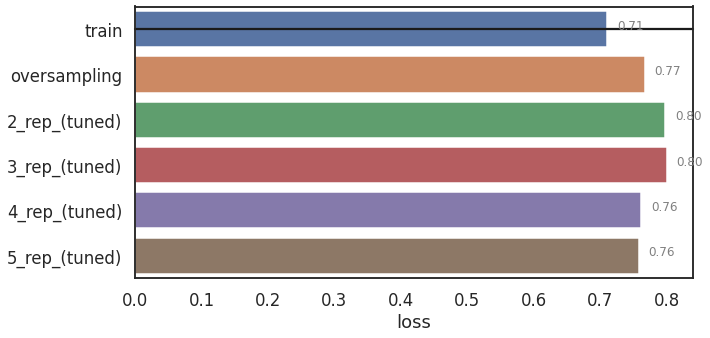

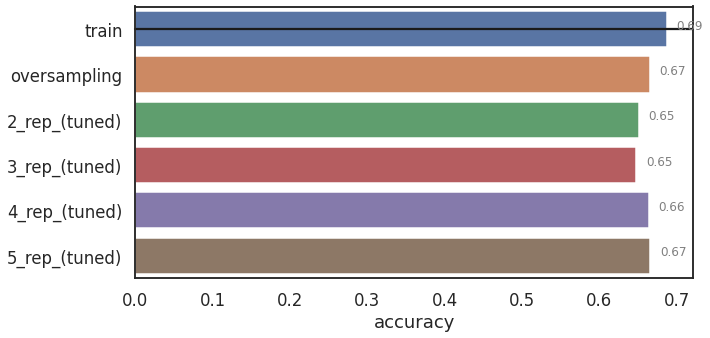

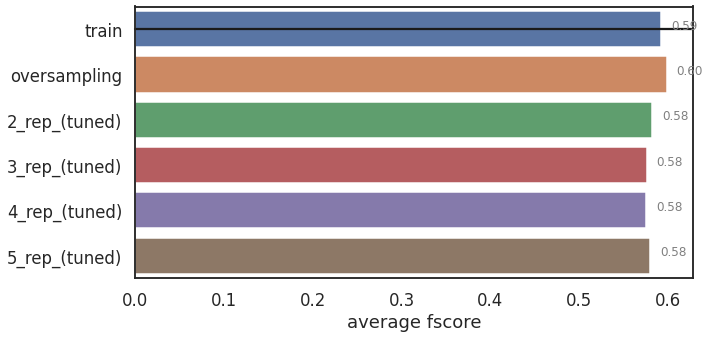

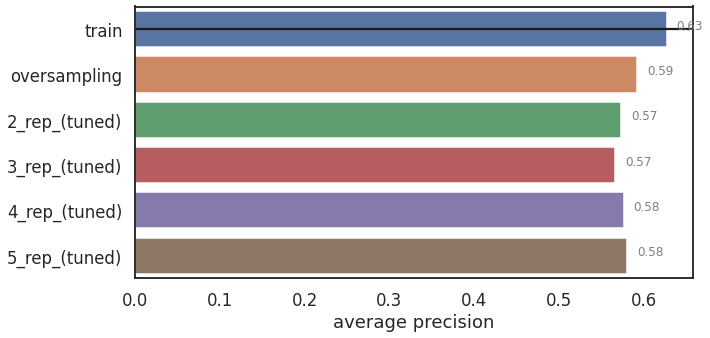

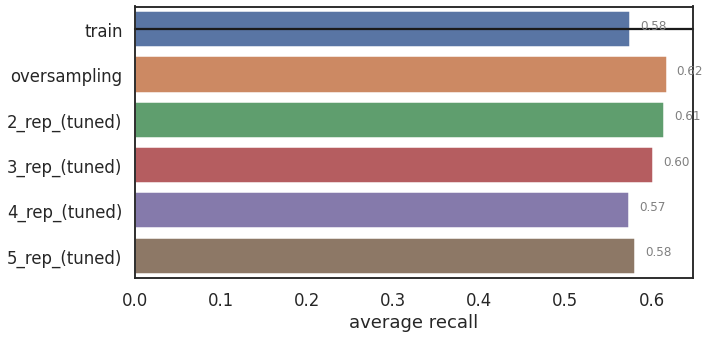

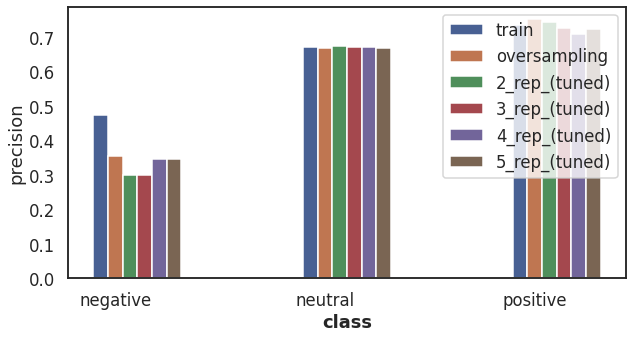

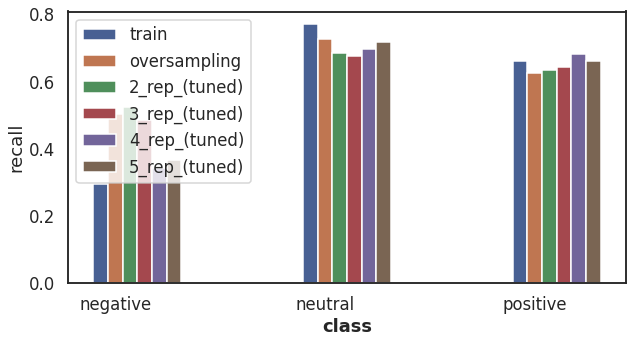

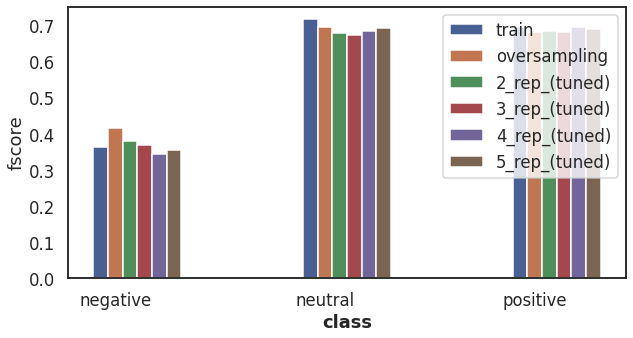

CPU times: user 1h 40min 23s, sys: 40min 3s, total: 2h 20min 27s
Wall time: 2h 20min 32s


In [13]:
%%time
test_list = [
              'train',
              'oversampling',
              '2_rep_(tuned)',
              '3_rep_(tuned)',
              '4_rep_(tuned)',
              '5_rep_(tuned)',
              # '6_rep_(tuned)'
              ]
              
task_name = 'sub_twitter'
tech_name = 'Bert_ data augmentation-master'

execute(test_list, tech_name, task_name)

## full data result